## Import Libraries & Dependencies

Let's begin by installing the following dependencies.

In [3]:
# %pip install tensorflow tensorflow-datasets matplotlib ipywidgets

In [4]:
# %pip install tensorflow_datasets

In [5]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

C:\Users\Janamejay\Documents\ImageClassification\imageclassification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use the `tensorflow_datasets` API to create a pipeline to the **training** split of the image dataset. Note that we're not *downloading* the entire dataset.

In [6]:
ds = tfds.load("fashion_mnist", split="train")

## Visualizing The Data

Create an **iterator** to return images from the dataset.

In [7]:
data_iterator = ds.as_numpy_iterator()

Visualize some images returned from the dataset by the iterator using `matplotlib`.

In [8]:
# Check image data structure shape
data_iterator.next()["image"].shape

(28, 28, 1)

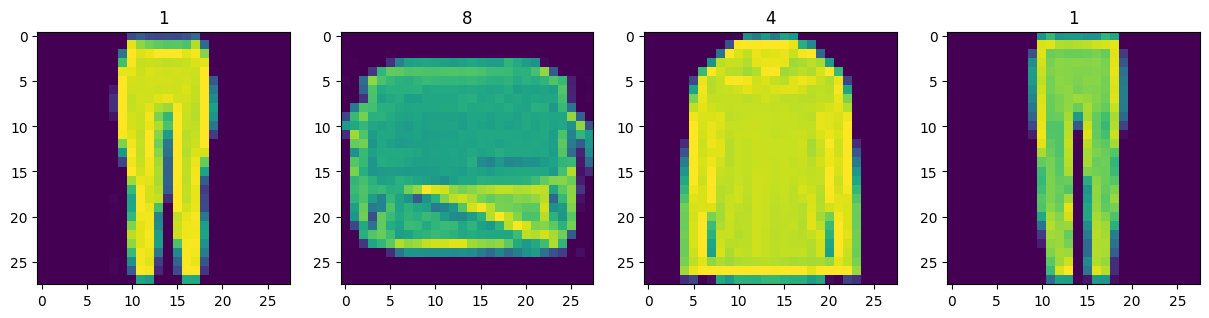

In [9]:
num_of_images = 4

(figure, subplots) =  plt.subplots(ncols=num_of_images, figsize=(15,15))

for subplot in subplots:
    # Get next image and label
    sample = data_iterator.next()
    
    # squeeze() changes image shape from (28,28,1) to (28,28)
    subplot.imshow(np.squeeze(sample["image"]))
    
    # Show each image's label above its visualization
    subplot.title.set_text(sample["label"])

## Building The Dataset

**Normalize** or apply **min-max scaling** to the images. Each attribute’s values are shifted and rescaled so that they end up between 0 and 1. Here, dividing each R, G, and B value by 255.

This is important because ML algorithms don’t perform well when the input numerical attributes have very different scales.


In [10]:
def scale_images(data):
    image = data["image"]
    return image / 255

ds = ds.map(scale_images)

**Cache** the data set to local storage to improve data loading performance.

Caching the dataset can be useful when working with large datasets that do not fit entirely in memory or when you want to avoid repeatedly loading data from a remote source, such as the internet.

By caching the dataset, subsequent accesses to the dataset will be faster since the data is already stored locally.

In [11]:
ds = ds.cache()

**Shuffle** the dataset.

In [12]:
ds = ds.shuffle(60000) # 60000 is the shuffle batch size

**Batch** the images into samples. 

In [13]:
images_per_sample = 128
ds = ds.batch(images_per_sample)

`prefetch()` is used to improve data loading performance by overlapping data loading and model execution. It prefetches a specified number of elements (usually batches) from the dataset.

In [14]:
ds = ds.prefetch(64)

Recreate the data iterator after these operations.

In [15]:
data_iterator = ds.as_numpy_iterator()
data_iterator.next().shape # Examine the new shape of next()'s return value

(128, 28, 28, 1)

## Building The Neural Networks

Import the model-building components.

In [16]:
from tensorflow.keras.models import Sequential  # One input, one output, flowing in one direction
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, LeakyReLU, UpSampling2D

Note about the **LeakyReLU** activation function:

[<img src="images/1_siH_yCvYJ9rqWSUYeDBiRA.png" width="500"/>](images/1_siH_yCvYJ9rqWSUYeDBiRA.png)

### Build The Generator

**Input Layer:** A dense, fully-connected layer. The generator is passed 128 random values (`input_dim`). These values determine what kind of image the generator will produce. The dimension 7\*7\*128 indicates a 7x7 array with 128 channels. 

**Activation:** The Leaky ReLU activation function provides the model **non-linearity**. 0.2 is the **output parameter** (0.01 in the image above).

**Reshape:** Takes in random values and reshapes it to 7x7x128.

**Upsampling Blocks:** Preserve the 128 channels of the input, specify a kernel size of 5x5, and set padding to **"same"** to prevent cropping.

`UpSampling2D()`**:** Duplicates the input dimensions (from 7x7x128 to 14x14x128)

In [17]:
def build_generator() -> Sequential:
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))


    # Convolutional block 1
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # Final convolutional layer to reduce to a single channel
    model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))


    return model

Test the model.

In [18]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 4s 4s/step


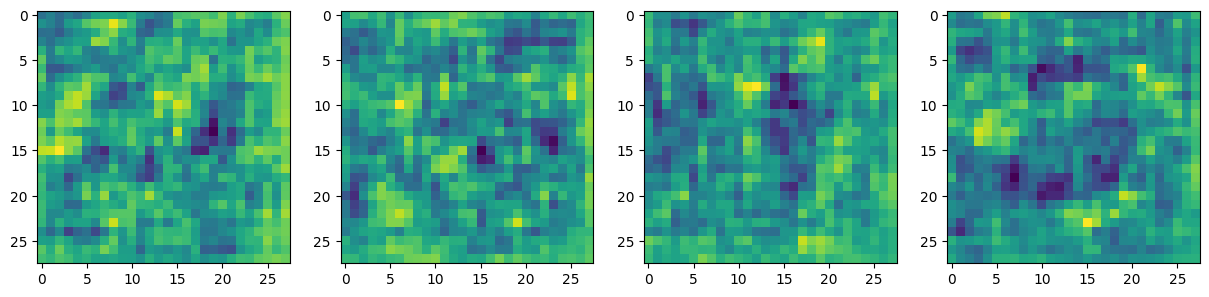

In [19]:
num_of_images = 4


img = generator.predict(np.random.randn(num_of_images,128,1))

(figure, subplots) =  plt.subplots(ncols=num_of_images, figsize=(15,15))

for i, img in enumerate(img):    
    # squeeze() changes image shape to (28,28)
    subplots[i].imshow(np.squeeze(img))

### Build The Discriminator

In [20]:
def build_discriminator():
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, 5, input_shape=(28,28,1))) # 32 filters of shape 5x5, input shape the same as generator's output
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 2
    model.add(Conv2D(64, 5)) # 64 filters.Not the input layer, so no need to specify input shape
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Output Layer
    model.add(Dense(1, activation="sigmoid")) # Outputs a single value, 1 representing a false image, 0 true

    return model

In [21]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

Now let's test the discrimnator. The neural network a expects a batch of images, rather a than a single image.

In [22]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 16ms/step


(4, 28, 28, 1)

In [23]:
discriminator.predict(img)

1/1 [==============================] - 0s 130ms/step


array([[0.50451744],
       [0.5044643 ],
       [0.50458974],
       [0.5044819 ]], dtype=float32)

If we wanted to test a single image (say `img[1]`) with the discriminator network, we would have to expand its dimensions.

In [24]:
discriminator.predict(np.expand_dims(img[1], axis=0)) # axis along which the dimensions are expanded

1/1 [==============================] - 0s 81ms/step


array([[0.5044643]], dtype=float32)

## Building The Training Loop

This part of building a GAN can be quite difficult. A balance needs to be struck between the learning rates of the generator and the discriminator.

We need to ensure that the discriminator doesn't learn too fast, otherwise it would be able to detect a false image every time. Adding random noise to the output of the discriminator can help to slow it down.

Because GANs are essentially two different neural networks, we can't simply use the `fit()` method to train them simultaneously.

### Setup Loss Functions & Optimizers
Both the generator and the discriminator will use the same loss function (`binary_crossentropy`) and optimizer (`Adam`).

The generator will use the `binary_crossentropy` loss function even though it is producing images. Its output is passed to the discriminator which has a binary output, and the generator's reward is based on this output.

In [25]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

gen_optimizer = Adam(learning_rate=0.0001)
disc_optimizer = Adam(learning_rate=0.00001) # Discriminator must learn slower than the generator

### Build Subclassed Model
In TensorFlow, a **subclassed** model refers to creating a custom neural network model by subclassing the `tf.keras.Model` class. This lets us define the model architecture and behavior by writing code in a more object-oriented manner, giving us greater flexibility and control over the model's structure and functionality.

In [26]:
from tensorflow.keras.models import Model
from tensorflow import GradientTape, concat, zeros_like, ones_like, random, shape

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass arguments and keyword arguments to the base class
        super().__init__(*args, **kwargs)

        # Attributes for the generator and discriminator
        self.generator = generator
        self.discriminator = discriminator


    def compile(self, gen_loss, disc_loss, gen_optimizer, disc_optimizer, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Attributes for losses and optimizers
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer


    # train_step() is called instead of fit() 
    def train_step(self, batch):
        # Get data
        real_images = batch
        fake_images = self.generator(np.random.randn(128,128,1), training=False)  # Each batch/sample has 128 images
        
        # Train the discriminator
        with GradientTape() as d_tape:
            # Pass the obtained real & fake images to the discriminator
            yHat_real = self.discriminator(real_images, training=True) # Setting training=True causes the Dropout layers to activate
            yHat_fake = self.discriminator(fake_images, training=True)

            # Concatenate the predicted (yHat) values into a single large array
            yHat_realfake = concat([yHat_real, yHat_fake], axis=0)

            # This is a supervised learning problem, so we need to create labels (the actual values)
            y_realfake = concat([zeros_like(yHat_real), ones_like(yHat_fake)], axis=0)

            # Add random noise to slow down discriminator training
            noise_real = 0.15 * random.uniform(shape(yHat_real))   # Add random values to zeroes in y_realfake
            noise_fake = -0.15 * random.uniform(shape(yHat_fake))  # Subtract random values from ones in y_realfake
            noise_realfake = concat([noise_real, noise_fake], axis=0)
            y_realfake += noise_realfake

            # Calculate loss
            total_disc_loss = self.disc_loss(y_realfake, yHat_realfake)

            # Apply backpropagation:
            # 1. Calculate gradient for each of the trainable_variables
            disc_gradient = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)

            # 2. Apply gradients to the optimizer. zip() used to apply gradients with respect to trainable_variables
            self.disc_optimizer.apply_gradients(zip(disc_gradient, self.discriminator.trainable_variables))

        # Train the generator
        with GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(np.random.randn(128,128,1), training=True) # 128 sets of 128 random floats

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # The goal is to trick the discriminator into thinking the images are real.
            # So we make all the labels 0, corresponding to real images (1 corresponds to fake images).
            generators_labels = zeros_like(predicted_labels)


            # Calculate loss.
            total_gen_loss = self.gen_loss(generators_labels, predicted_labels)

            # Apply backpropagation
            # 1. Calculate gradient for each of the trainable_variables
            gen_gradient = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)

            # 2. Apply gradients to the optimizer. zip() used to apply gradients with respect to trainable_variables
            self.gen_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"discriminator_loss":total_disc_loss,
                "generator_loss": total_gen_loss}

In [27]:
# Create an instance of the subclassed model
fashGAN = FashionGAN(generator, discriminator)

# Compile the instance
fashGAN.compile(gen_loss, disc_loss, gen_optimizer, disc_optimizer)

### Build Callbacks (Optional)

The following `ModelMonitor` class allows us to save the images as they are generated.

In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128): # latent_dim is the number of random values passed to the generator
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = np.random.randn(self.num_img, self.latent_dim, 1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

During training, it is usually the case that the final model is not the best in terms of the desired metric. This can be problematic and lead to wasted compute time given the stochastic nature of these models. **Checkpointing** allows us to save the model at a given frequency as it trains. We won't be using the `tf.keras.callbacks.ModelCheckpoint` callback since we're using a subclassed model.

In [29]:
import os
from tensorflow.keras.callbacks import Callback

class SaveModel(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(os.path.join('models', f"g_{epoch}.h5"))
        self.model.discriminator.save(os.path.join('models', f"d_{epoch}.h5"))

### Train Subclassed Model

In [29]:
# Recommended epochs=2000
history = fashGAN.fit(ds, epochs=500, callbacks=[ModelMonitor(), SaveModel()])  # callbacks optional

Epoch 1/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5297 - generator_loss: 0.8733

469/469 [==============================] - 59s 119ms/step - discriminator_loss: 0.5295 - generator_loss: 0.8736
Epoch 2/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6210 - generator_loss: 0.8147

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.6211 - generator_loss: 0.8143
Epoch 3/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5934 - generator_loss: 0.3802

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.5931 - generator_loss: 0.3797
Epoch 4/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6195 - generator_loss: 0.3369

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.6193 - generator_loss: 0.3370
Epoch 5/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4485 - generator_loss: 0.1890

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.4485 - generator_loss: 0.1888
Epoch 6/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3551 - generator_loss: 0.0394

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3551 - generator_loss: 0.0394
Epoch 7/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3343 - generator_loss: 0.0416

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3342 - generator_loss: 0.0416
Epoch 8/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3273 - generator_loss: 0.0324

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.3273 - generator_loss: 0.0324
Epoch 9/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6031 - generator_loss: 0.2887

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.6032 - generator_loss: 0.2893
Epoch 10/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6660 - generator_loss: 0.4902

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.6660 - generator_loss: 0.4901
Epoch 11/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6648 - generator_loss: 0.4891

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.6649 - generator_loss: 0.4892
Epoch 12/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6263 - generator_loss: 0.4520

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.6265 - generator_loss: 0.4519
Epoch 13/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6305 - generator_loss: 0.4403

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.6305 - generator_loss: 0.4403
Epoch 14/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6193 - generator_loss: 0.4103

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.6195 - generator_loss: 0.4104
Epoch 15/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6129 - generator_loss: 0.4343

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.6131 - generator_loss: 0.4343
Epoch 16/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6236 - generator_loss: 0.4428

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.6232 - generator_loss: 0.4429
Epoch 17/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6091 - generator_loss: 0.4220

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.6091 - generator_loss: 0.4221
Epoch 18/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6316 - generator_loss: 0.4552

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.6315 - generator_loss: 0.4553
Epoch 19/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6309 - generator_loss: 0.4602

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.6308 - generator_loss: 0.4602
Epoch 20/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5776 - generator_loss: 0.4565

469/469 [==============================] - 53s 114ms/step - discriminator_loss: 0.5778 - generator_loss: 0.4563
Epoch 21/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6491 - generator_loss: 0.4282

469/469 [==============================] - 52s 112ms/step - discriminator_loss: 0.6490 - generator_loss: 0.4282
Epoch 22/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6079 - generator_loss: 0.4310

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.6079 - generator_loss: 0.4311
Epoch 23/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5993 - generator_loss: 0.4050

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.5994 - generator_loss: 0.4049
Epoch 24/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6062 - generator_loss: 0.4180

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.6069 - generator_loss: 0.4175
Epoch 25/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6246 - generator_loss: 0.4043

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.6247 - generator_loss: 0.4042
Epoch 26/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5944 - generator_loss: 0.3975

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.5944 - generator_loss: 0.3980
Epoch 27/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5511 - generator_loss: 0.4122

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.5511 - generator_loss: 0.4122
Epoch 28/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5289 - generator_loss: 0.3679

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.5291 - generator_loss: 0.3678
Epoch 29/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4557 - generator_loss: 0.3876

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.4562 - generator_loss: 0.3871
Epoch 30/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4643 - generator_loss: 0.2999

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.4643 - generator_loss: 0.2999
Epoch 31/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5190 - generator_loss: 0.2825

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.5188 - generator_loss: 0.2824
Epoch 32/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5564 - generator_loss: 0.2525

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.5561 - generator_loss: 0.2524
Epoch 33/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4878 - generator_loss: 0.1834

469/469 [==============================] - 55s 116ms/step - discriminator_loss: 0.4879 - generator_loss: 0.1834
Epoch 34/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4363 - generator_loss: 0.2661

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.4364 - generator_loss: 0.2662
Epoch 35/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4496 - generator_loss: 0.2771

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.4497 - generator_loss: 0.2768
Epoch 36/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4714 - generator_loss: 0.2676

469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.4718 - generator_loss: 0.2675
Epoch 37/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5032 - generator_loss: 0.2898

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.5030 - generator_loss: 0.2896
Epoch 38/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4557 - generator_loss: 0.2650

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4557 - generator_loss: 0.2652
Epoch 39/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4446 - generator_loss: 0.2298

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4446 - generator_loss: 0.2298
Epoch 40/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4392 - generator_loss: 0.2286

469/469 [==============================] - 58s 124ms/step - discriminator_loss: 0.4392 - generator_loss: 0.2284
Epoch 41/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4068 - generator_loss: 0.2600

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4068 - generator_loss: 0.2601
Epoch 42/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4188 - generator_loss: 0.1598

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4188 - generator_loss: 0.1597
Epoch 43/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4258 - generator_loss: 0.1885

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4258 - generator_loss: 0.1884
Epoch 44/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3855 - generator_loss: 0.2177

469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.3855 - generator_loss: 0.2177
Epoch 45/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4172 - generator_loss: 0.4662

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.4173 - generator_loss: 0.4657
Epoch 46/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4353 - generator_loss: 0.3240

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.4353 - generator_loss: 0.3240
Epoch 47/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4536 - generator_loss: 0.3252

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.4536 - generator_loss: 0.3251
Epoch 48/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4284 - generator_loss: 0.3003

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.4283 - generator_loss: 0.3009
Epoch 49/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4219 - generator_loss: 0.2191

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.4218 - generator_loss: 0.2191
Epoch 50/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3915 - generator_loss: 0.3109

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3915 - generator_loss: 0.3110
Epoch 51/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4024 - generator_loss: 0.2605

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.4023 - generator_loss: 0.2605
Epoch 52/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3745 - generator_loss: 0.3009

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3744 - generator_loss: 0.3012
Epoch 53/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3768 - generator_loss: 0.2681

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3768 - generator_loss: 0.2684
Epoch 54/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3914 - generator_loss: 0.3180

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3913 - generator_loss: 0.3177
Epoch 55/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3834 - generator_loss: 0.2510

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3833 - generator_loss: 0.2516
Epoch 56/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.4073 - generator_loss: 0.2779

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.4072 - generator_loss: 0.2777
Epoch 57/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3696 - generator_loss: 0.2506

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3696 - generator_loss: 0.2505
Epoch 58/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3854 - generator_loss: 0.2427

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3853 - generator_loss: 0.2427
Epoch 59/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3642 - generator_loss: 0.1917

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3642 - generator_loss: 0.1915
Epoch 60/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3739 - generator_loss: 0.2181

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3739 - generator_loss: 0.2181
Epoch 61/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3863 - generator_loss: 0.2484

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3863 - generator_loss: 0.2483
Epoch 62/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3725 - generator_loss: 0.2396

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3725 - generator_loss: 0.2396
Epoch 63/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3934 - generator_loss: 0.2457

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3935 - generator_loss: 0.2459
Epoch 64/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3251 - generator_loss: 0.6178

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3250 - generator_loss: 0.6178
Epoch 65/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3755 - generator_loss: 0.3707

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3754 - generator_loss: 0.3703
Epoch 66/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3423 - generator_loss: 0.1125

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3423 - generator_loss: 0.1124
Epoch 67/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3429 - generator_loss: 0.3151

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.3428 - generator_loss: 0.3146
Epoch 68/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3293 - generator_loss: 0.0415

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.3293 - generator_loss: 0.0415
Epoch 69/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3204 - generator_loss: 0.0628

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3204 - generator_loss: 0.0629
Epoch 70/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3411 - generator_loss: 0.2465

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3412 - generator_loss: 0.2469
Epoch 71/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3723 - generator_loss: 0.2360

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3723 - generator_loss: 0.2359
Epoch 72/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3520 - generator_loss: 0.3916

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.3520 - generator_loss: 0.3911
Epoch 73/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3659 - generator_loss: 0.2323

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3658 - generator_loss: 0.2322
Epoch 74/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3359 - generator_loss: 0.2322

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.3360 - generator_loss: 0.2322
Epoch 75/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3521 - generator_loss: 0.3547

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.3520 - generator_loss: 0.3543
Epoch 76/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3004 - generator_loss: 0.3093

469/469 [==============================] - 52s 112ms/step - discriminator_loss: 0.3004 - generator_loss: 0.3095
Epoch 77/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3213 - generator_loss: 0.3472

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.3213 - generator_loss: 0.3480
Epoch 78/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3212 - generator_loss: 0.5360

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3214 - generator_loss: 0.5356
Epoch 79/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3732 - generator_loss: 0.2081

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3731 - generator_loss: 0.2085
Epoch 80/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3502 - generator_loss: 0.1498

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3502 - generator_loss: 0.1499
Epoch 81/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3223 - generator_loss: 0.2679

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3222 - generator_loss: 0.2684
Epoch 82/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3484 - generator_loss: 0.2132

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3483 - generator_loss: 0.2135
Epoch 83/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3268 - generator_loss: 0.1430

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3268 - generator_loss: 0.1429
Epoch 84/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3327 - generator_loss: 0.0892

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3328 - generator_loss: 0.0892
Epoch 85/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3490 - generator_loss: 0.1747

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3490 - generator_loss: 0.1752
Epoch 86/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3521 - generator_loss: 0.2757

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3521 - generator_loss: 0.2754
Epoch 87/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3548 - generator_loss: 0.1421

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3548 - generator_loss: 0.1419
Epoch 88/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3368 - generator_loss: 0.3472

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3368 - generator_loss: 0.3470
Epoch 89/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3423 - generator_loss: 0.2183

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3424 - generator_loss: 0.2179
Epoch 90/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3367 - generator_loss: 0.1086

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3367 - generator_loss: 0.1086
Epoch 91/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3172 - generator_loss: 0.3269

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3171 - generator_loss: 0.3272
Epoch 92/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2986 - generator_loss: 0.4093

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2986 - generator_loss: 0.4089
Epoch 93/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3518 - generator_loss: 0.2081

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3517 - generator_loss: 0.2077
Epoch 94/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2953 - generator_loss: 0.0317

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2953 - generator_loss: 0.0317
Epoch 95/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2929 - generator_loss: 0.0215

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2929 - generator_loss: 0.0215
Epoch 96/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2887 - generator_loss: 0.0209

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2887 - generator_loss: 0.0209
Epoch 97/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2848 - generator_loss: 0.0215

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2848 - generator_loss: 0.0215
Epoch 98/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2855 - generator_loss: 0.0231

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2855 - generator_loss: 0.0231
Epoch 99/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2839 - generator_loss: 0.0223

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2839 - generator_loss: 0.0223
Epoch 100/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2848 - generator_loss: 0.0191

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2848 - generator_loss: 0.0191
Epoch 101/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2935 - generator_loss: 0.0675

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2935 - generator_loss: 0.0689
Epoch 102/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2935 - generator_loss: 0.4715

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2934 - generator_loss: 0.4715
Epoch 103/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2933 - generator_loss: 0.4683

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2933 - generator_loss: 0.4681
Epoch 104/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2852 - generator_loss: 0.1789

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2852 - generator_loss: 0.1787
Epoch 105/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3000 - generator_loss: 0.0565

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3000 - generator_loss: 0.0565
Epoch 106/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3170 - generator_loss: 0.0722

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3169 - generator_loss: 0.0722
Epoch 107/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3332 - generator_loss: 0.1192

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3332 - generator_loss: 0.1191
Epoch 108/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3200 - generator_loss: 0.1412

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3199 - generator_loss: 0.1412
Epoch 109/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3363 - generator_loss: 0.1526

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3363 - generator_loss: 0.1535
Epoch 110/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3351 - generator_loss: 0.1825

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3352 - generator_loss: 0.1826
Epoch 111/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3346 - generator_loss: 0.2552

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3346 - generator_loss: 0.2552
Epoch 112/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3391 - generator_loss: 0.2909

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3392 - generator_loss: 0.2908
Epoch 113/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3814 - generator_loss: 0.4225

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3815 - generator_loss: 0.4220
Epoch 114/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3684 - generator_loss: 0.1568

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3684 - generator_loss: 0.1568
Epoch 115/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3467 - generator_loss: 0.1696

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3467 - generator_loss: 0.1697
Epoch 116/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3576 - generator_loss: 0.1561

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3575 - generator_loss: 0.1560
Epoch 117/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3613 - generator_loss: 0.1670

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3613 - generator_loss: 0.1669
Epoch 118/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3432 - generator_loss: 0.2545

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3432 - generator_loss: 0.2542
Epoch 119/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3339 - generator_loss: 0.1804

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3338 - generator_loss: 0.1801
Epoch 120/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3057 - generator_loss: 0.0565

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3058 - generator_loss: 0.0565
Epoch 121/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3132 - generator_loss: 0.0512

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.3132 - generator_loss: 0.0512
Epoch 122/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3343 - generator_loss: 0.2016

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3343 - generator_loss: 0.2013
Epoch 123/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3315 - generator_loss: 0.1449

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3315 - generator_loss: 0.1448
Epoch 124/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3363 - generator_loss: 0.2523

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3362 - generator_loss: 0.2519
Epoch 125/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3189 - generator_loss: 0.0714

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3193 - generator_loss: 0.0717
Epoch 126/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3122 - generator_loss: 0.1176

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3121 - generator_loss: 0.1175
Epoch 127/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3165 - generator_loss: 0.0776

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3165 - generator_loss: 0.0776
Epoch 128/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3195 - generator_loss: 0.2143

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3194 - generator_loss: 0.2145
Epoch 129/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3103 - generator_loss: 0.2679

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3103 - generator_loss: 0.2675
Epoch 130/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3190 - generator_loss: 0.1031

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3190 - generator_loss: 0.1031
Epoch 131/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3102 - generator_loss: 0.2694

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3102 - generator_loss: 0.2702
Epoch 132/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3157 - generator_loss: 0.2129

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3156 - generator_loss: 0.2134
Epoch 133/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2971 - generator_loss: 0.3789

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.2973 - generator_loss: 0.3783
Epoch 134/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3286 - generator_loss: 0.2185

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3287 - generator_loss: 0.2183
Epoch 135/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3172 - generator_loss: 0.1197

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3172 - generator_loss: 0.1197
Epoch 136/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3357 - generator_loss: 0.2155

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3356 - generator_loss: 0.2155
Epoch 137/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3450 - generator_loss: 0.1925

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3449 - generator_loss: 0.1925
Epoch 138/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3161 - generator_loss: 0.1201

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.3160 - generator_loss: 0.1202
Epoch 139/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3286 - generator_loss: 0.2715

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3286 - generator_loss: 0.2721
Epoch 140/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2852 - generator_loss: 0.4510

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2852 - generator_loss: 0.4512
Epoch 141/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2796 - generator_loss: 0.5680

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2796 - generator_loss: 0.5680
Epoch 142/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2991 - generator_loss: 0.2605

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2990 - generator_loss: 0.2602
Epoch 143/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3206 - generator_loss: 0.1555

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3206 - generator_loss: 0.1558
Epoch 144/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3255 - generator_loss: 0.2635

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3255 - generator_loss: 0.2638
Epoch 145/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3507 - generator_loss: 0.2715

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3507 - generator_loss: 0.2715
Epoch 146/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3400 - generator_loss: 0.3606

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3400 - generator_loss: 0.3606
Epoch 147/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2905 - generator_loss: 0.5883

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2905 - generator_loss: 0.5886
Epoch 148/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2854 - generator_loss: 0.8059

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2853 - generator_loss: 0.8061
Epoch 149/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2858 - generator_loss: 0.8697

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2859 - generator_loss: 0.8684
Epoch 150/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3485 - generator_loss: 0.3021

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3485 - generator_loss: 0.3015
Epoch 151/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3093 - generator_loss: 0.0554

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3094 - generator_loss: 0.0554
Epoch 152/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3110 - generator_loss: 0.0603

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3110 - generator_loss: 0.0603
Epoch 153/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3714 - generator_loss: 0.1794

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3713 - generator_loss: 0.1794
Epoch 154/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3762 - generator_loss: 0.1305

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3761 - generator_loss: 0.1303
Epoch 155/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3494 - generator_loss: 0.1087

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3494 - generator_loss: 0.1087
Epoch 156/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3235 - generator_loss: 0.1772

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3234 - generator_loss: 0.1775
Epoch 157/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3398 - generator_loss: 0.2296

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3397 - generator_loss: 0.2293
Epoch 158/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3369 - generator_loss: 0.1406

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3369 - generator_loss: 0.1405
Epoch 159/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3188 - generator_loss: 0.1397

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3188 - generator_loss: 0.1396
Epoch 160/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3249 - generator_loss: 0.3991

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3249 - generator_loss: 0.3992
Epoch 161/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3455 - generator_loss: 0.4002

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3456 - generator_loss: 0.4000
Epoch 162/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3434 - generator_loss: 0.1672

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3433 - generator_loss: 0.1671
Epoch 163/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3462 - generator_loss: 0.0950

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3462 - generator_loss: 0.0949
Epoch 164/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3255 - generator_loss: 0.3268

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3255 - generator_loss: 0.3264
Epoch 165/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3097 - generator_loss: 0.1266

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3097 - generator_loss: 0.1265
Epoch 166/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3028 - generator_loss: 0.0994

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3028 - generator_loss: 0.0996
Epoch 167/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3154 - generator_loss: 0.1395

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3154 - generator_loss: 0.1396
Epoch 168/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3024 - generator_loss: 0.1410

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3025 - generator_loss: 0.1413
Epoch 169/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3203 - generator_loss: 0.2198

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3203 - generator_loss: 0.2195
Epoch 170/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3252 - generator_loss: 0.1919

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3252 - generator_loss: 0.1916
Epoch 171/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3041 - generator_loss: 0.0322

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3041 - generator_loss: 0.0322
Epoch 172/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3076 - generator_loss: 0.2824

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3076 - generator_loss: 0.2819
Epoch 173/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3096 - generator_loss: 0.1956

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3095 - generator_loss: 0.1972
Epoch 174/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3012 - generator_loss: 0.4715

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3012 - generator_loss: 0.4710
Epoch 175/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3070 - generator_loss: 0.1148

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3069 - generator_loss: 0.1149
Epoch 176/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3185 - generator_loss: 0.1203

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3185 - generator_loss: 0.1201
Epoch 177/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3182 - generator_loss: 0.0971

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3183 - generator_loss: 0.0970
Epoch 178/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3209 - generator_loss: 0.2989

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3209 - generator_loss: 0.2994
Epoch 179/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3062 - generator_loss: 0.3036

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.3062 - generator_loss: 0.3032
Epoch 180/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3092 - generator_loss: 0.1087

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3092 - generator_loss: 0.1087
Epoch 181/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3123 - generator_loss: 0.1650

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3123 - generator_loss: 0.1652
Epoch 182/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3204 - generator_loss: 0.1275

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3204 - generator_loss: 0.1273
Epoch 183/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3070 - generator_loss: 0.2689

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.3069 - generator_loss: 0.2696
Epoch 184/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2893 - generator_loss: 0.0789

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2893 - generator_loss: 0.0787
Epoch 185/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2861 - generator_loss: 0.0288

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2861 - generator_loss: 0.0288
Epoch 186/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2903 - generator_loss: 0.0419

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2903 - generator_loss: 0.0418
Epoch 187/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2816 - generator_loss: 0.0207

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2816 - generator_loss: 0.0207
Epoch 188/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2800 - generator_loss: 0.0134

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2800 - generator_loss: 0.0134
Epoch 189/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2800 - generator_loss: 0.0096

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2799 - generator_loss: 0.0096
Epoch 190/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2770 - generator_loss: 0.0095

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2771 - generator_loss: 0.0095
Epoch 191/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2761 - generator_loss: 0.0082

469/469 [==============================] - 50s 107ms/step - discriminator_loss: 0.2761 - generator_loss: 0.0082
Epoch 192/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2753 - generator_loss: 0.0073

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.2753 - generator_loss: 0.0073
Epoch 193/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2752 - generator_loss: 0.0087

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.2752 - generator_loss: 0.0087
Epoch 194/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2895 - generator_loss: 0.6012

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.2895 - generator_loss: 0.6006
Epoch 195/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2824 - generator_loss: 0.6636

469/469 [==============================] - 50s 108ms/step - discriminator_loss: 0.2824 - generator_loss: 0.6639
Epoch 196/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2853 - generator_loss: 0.7758

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.2853 - generator_loss: 0.7761
Epoch 197/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2939 - generator_loss: 0.8813

469/469 [==============================] - 58s 123ms/step - discriminator_loss: 0.2940 - generator_loss: 0.8806
Epoch 198/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3257 - generator_loss: 0.2614

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3258 - generator_loss: 0.2610
Epoch 199/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3189 - generator_loss: 0.1434

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3188 - generator_loss: 0.1433
Epoch 200/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3345 - generator_loss: 0.1927

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3345 - generator_loss: 0.1925
Epoch 201/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3251 - generator_loss: 0.4357

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.3251 - generator_loss: 0.4368
Epoch 202/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3085 - generator_loss: 0.4052

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.3085 - generator_loss: 0.4044
Epoch 203/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2986 - generator_loss: 0.0338

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2986 - generator_loss: 0.0338
Epoch 204/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2899 - generator_loss: 0.0293

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2898 - generator_loss: 0.0293
Epoch 205/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2846 - generator_loss: 0.0214

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2846 - generator_loss: 0.0214
Epoch 206/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2835 - generator_loss: 0.0159

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2835 - generator_loss: 0.0159
Epoch 207/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2849 - generator_loss: 0.0191

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2849 - generator_loss: 0.0191
Epoch 208/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2804 - generator_loss: 0.0151

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2804 - generator_loss: 0.0151
Epoch 209/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2785 - generator_loss: 0.0126

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2785 - generator_loss: 0.0126
Epoch 210/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2839 - generator_loss: 0.1113

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2839 - generator_loss: 0.1121
Epoch 211/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3065 - generator_loss: 0.1898

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3065 - generator_loss: 0.1894
Epoch 212/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2983 - generator_loss: 0.0324

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2983 - generator_loss: 0.0324
Epoch 213/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2910 - generator_loss: 0.0187

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2910 - generator_loss: 0.0187
Epoch 214/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2890 - generator_loss: 0.0137

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2890 - generator_loss: 0.0137
Epoch 215/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2852 - generator_loss: 0.0084

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2852 - generator_loss: 0.0084
Epoch 216/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2831 - generator_loss: 0.0079

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2831 - generator_loss: 0.0079
Epoch 217/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2812 - generator_loss: 0.0075

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2812 - generator_loss: 0.0075
Epoch 218/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2807 - generator_loss: 0.0069

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2807 - generator_loss: 0.0069
Epoch 219/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2799 - generator_loss: 0.0061

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2799 - generator_loss: 0.0061
Epoch 220/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2955 - generator_loss: 0.1021

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2955 - generator_loss: 0.1020
Epoch 221/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2957 - generator_loss: 0.0425

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2957 - generator_loss: 0.0425
Epoch 222/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2942 - generator_loss: 0.0855

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2942 - generator_loss: 0.0855
Epoch 223/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3013 - generator_loss: 0.0414

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3013 - generator_loss: 0.0413
Epoch 224/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2858 - generator_loss: 0.0166

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2859 - generator_loss: 0.0166
Epoch 225/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2837 - generator_loss: 0.0189

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2836 - generator_loss: 0.0189
Epoch 226/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2822 - generator_loss: 0.0236

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2822 - generator_loss: 0.0237
Epoch 227/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2816 - generator_loss: 0.0243

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2817 - generator_loss: 0.0242
Epoch 228/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2840 - generator_loss: 0.0153

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2840 - generator_loss: 0.0153
Epoch 229/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2833 - generator_loss: 0.0084

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2833 - generator_loss: 0.0084
Epoch 230/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2801 - generator_loss: 0.0091

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2800 - generator_loss: 0.0091
Epoch 231/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2943 - generator_loss: 0.0790

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2943 - generator_loss: 0.0790
Epoch 232/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2987 - generator_loss: 0.0166

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2987 - generator_loss: 0.0166
Epoch 233/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3153 - generator_loss: 0.1003

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.3153 - generator_loss: 0.1001
Epoch 234/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2936 - generator_loss: 0.0102

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2936 - generator_loss: 0.0102
Epoch 235/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2874 - generator_loss: 0.0078

469/469 [==============================] - 51s 109ms/step - discriminator_loss: 0.2874 - generator_loss: 0.0078
Epoch 236/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2835 - generator_loss: 0.0052

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.2835 - generator_loss: 0.0052
Epoch 237/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2811 - generator_loss: 0.0041

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2811 - generator_loss: 0.0041
Epoch 238/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2804 - generator_loss: 0.0035

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2803 - generator_loss: 0.0035
Epoch 239/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2796 - generator_loss: 0.0031

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.2796 - generator_loss: 0.0031
Epoch 240/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2795 - generator_loss: 0.0028

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.2795 - generator_loss: 0.0028
Epoch 241/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2791 - generator_loss: 0.0027

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2791 - generator_loss: 0.0027
Epoch 242/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2787 - generator_loss: 0.0026

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2788 - generator_loss: 0.0026
Epoch 243/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2782 - generator_loss: 0.0026

469/469 [==============================] - 57s 123ms/step - discriminator_loss: 0.2782 - generator_loss: 0.0026
Epoch 244/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2770 - generator_loss: 0.0024

469/469 [==============================] - 58s 124ms/step - discriminator_loss: 0.2770 - generator_loss: 0.0024
Epoch 245/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2771 - generator_loss: 0.0021

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.2771 - generator_loss: 0.0021
Epoch 246/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2763 - generator_loss: 0.0019

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.2763 - generator_loss: 0.0019
Epoch 247/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2761 - generator_loss: 0.0017

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.2761 - generator_loss: 0.0017
Epoch 248/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2752 - generator_loss: 0.0017

469/469 [==============================] - 55s 116ms/step - discriminator_loss: 0.2752 - generator_loss: 0.0017
Epoch 249/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2759 - generator_loss: 0.0017

469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.2759 - generator_loss: 0.0017
Epoch 250/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2749 - generator_loss: 0.0016

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.2749 - generator_loss: 0.0016
Epoch 251/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2746 - generator_loss: 0.0016

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.2747 - generator_loss: 0.0016
Epoch 252/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2744 - generator_loss: 0.0016

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.2744 - generator_loss: 0.0016
Epoch 253/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2754 - generator_loss: 0.0015

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2754 - generator_loss: 0.0015
Epoch 254/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3036 - generator_loss: 0.1058

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.3037 - generator_loss: 0.1056
Epoch 255/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3012 - generator_loss: 0.0198

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.3012 - generator_loss: 0.0198
Epoch 256/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3025 - generator_loss: 0.0517

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.3024 - generator_loss: 0.0517
Epoch 257/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3086 - generator_loss: 0.0661

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.3086 - generator_loss: 0.0660
Epoch 258/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2892 - generator_loss: 0.0107

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.2891 - generator_loss: 0.0107
Epoch 259/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2841 - generator_loss: 0.0067

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.2841 - generator_loss: 0.0067
Epoch 260/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2828 - generator_loss: 0.0051

469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.2828 - generator_loss: 0.0051
Epoch 261/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2814 - generator_loss: 0.0044

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.2814 - generator_loss: 0.0044
Epoch 262/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3130 - generator_loss: 0.1512

469/469 [==============================] - 53s 112ms/step - discriminator_loss: 0.3131 - generator_loss: 0.1512
Epoch 263/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2998 - generator_loss: 0.0178

469/469 [==============================] - 54s 114ms/step - discriminator_loss: 0.2998 - generator_loss: 0.0178
Epoch 264/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3010 - generator_loss: 0.0428

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.3010 - generator_loss: 0.0428
Epoch 265/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2935 - generator_loss: 0.0103

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2934 - generator_loss: 0.0103
Epoch 266/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2870 - generator_loss: 0.0026

469/469 [==============================] - 52s 112ms/step - discriminator_loss: 0.2870 - generator_loss: 0.0026
Epoch 267/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2833 - generator_loss: 0.0019

469/469 [==============================] - 54s 114ms/step - discriminator_loss: 0.2833 - generator_loss: 0.0019
Epoch 268/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2812 - generator_loss: 0.0015

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2812 - generator_loss: 0.0015
Epoch 269/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2798 - generator_loss: 0.0012

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2798 - generator_loss: 0.0012
Epoch 270/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2778 - generator_loss: 0.0011

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.2778 - generator_loss: 0.0011
Epoch 271/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2769 - generator_loss: 0.0010

469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.2769 - generator_loss: 0.0010
Epoch 272/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2763 - generator_loss: 9.9933e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2764 - generator_loss: 9.9932e-04
Epoch 273/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2763 - generator_loss: 9.4431e-04

469/469 [==============================] - 56s 120ms/step - discriminator_loss: 0.2763 - generator_loss: 9.4423e-04
Epoch 274/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2754 - generator_loss: 9.0799e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2754 - generator_loss: 9.0785e-04
Epoch 275/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2748 - generator_loss: 9.1516e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2748 - generator_loss: 9.1516e-04
Epoch 276/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2749 - generator_loss: 9.0900e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2749 - generator_loss: 9.0895e-04
Epoch 277/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2753 - generator_loss: 9.1468e-04

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.2753 - generator_loss: 9.1518e-04
Epoch 278/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2744 - generator_loss: 9.6742e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2744 - generator_loss: 9.6722e-04
Epoch 279/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2745 - generator_loss: 8.4984e-04

469/469 [==============================] - 56s 120ms/step - discriminator_loss: 0.2745 - generator_loss: 8.5013e-04
Epoch 280/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2735 - generator_loss: 8.0228e-04

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.2735 - generator_loss: 8.0215e-04
Epoch 281/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2735 - generator_loss: 7.6508e-04

469/469 [==============================] - 57s 121ms/step - discriminator_loss: 0.2735 - generator_loss: 7.6506e-04
Epoch 282/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2739 - generator_loss: 7.5957e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2739 - generator_loss: 7.5961e-04
Epoch 283/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2734 - generator_loss: 7.7876e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2734 - generator_loss: 7.7881e-04
Epoch 284/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3028 - generator_loss: 0.1232

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.3027 - generator_loss: 0.1229
Epoch 285/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2808 - generator_loss: 0.0034

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2808 - generator_loss: 0.0033
Epoch 286/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2771 - generator_loss: 0.0014

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2771 - generator_loss: 0.0014
Epoch 287/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2753 - generator_loss: 0.0013

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.2753 - generator_loss: 0.0013
Epoch 288/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2741 - generator_loss: 0.0013

469/469 [==============================] - 51s 108ms/step - discriminator_loss: 0.2741 - generator_loss: 0.0013
Epoch 289/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2735 - generator_loss: 0.0015

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2735 - generator_loss: 0.0015
Epoch 290/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2740 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2740 - generator_loss: 0.0016
Epoch 291/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2729 - generator_loss: 0.0020

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2729 - generator_loss: 0.0020
Epoch 292/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2731 - generator_loss: 0.0026

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2731 - generator_loss: 0.0026
Epoch 293/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2732 - generator_loss: 0.0027

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2732 - generator_loss: 0.0027
Epoch 294/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2729 - generator_loss: 0.0021

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2729 - generator_loss: 0.0021
Epoch 295/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2728 - generator_loss: 0.0023

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2728 - generator_loss: 0.0023
Epoch 296/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3207 - generator_loss: 0.1515

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.3207 - generator_loss: 0.1512
Epoch 297/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3163 - generator_loss: 0.1242

469/469 [==============================] - 57s 122ms/step - discriminator_loss: 0.3162 - generator_loss: 0.1239
Epoch 298/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2936 - generator_loss: 0.0162

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.2936 - generator_loss: 0.0162
Epoch 299/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2943 - generator_loss: 0.0285

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2943 - generator_loss: 0.0284
Epoch 300/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2818 - generator_loss: 0.0128

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2818 - generator_loss: 0.0128
Epoch 301/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3023 - generator_loss: 0.0959

469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.3023 - generator_loss: 0.0961
Epoch 302/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2934 - generator_loss: 0.0847

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2934 - generator_loss: 0.0846
Epoch 303/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2874 - generator_loss: 0.0075

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2874 - generator_loss: 0.0075
Epoch 304/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2827 - generator_loss: 0.0089

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2827 - generator_loss: 0.0089
Epoch 305/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3021 - generator_loss: 0.0735

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.3021 - generator_loss: 0.0734
Epoch 306/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2901 - generator_loss: 0.0268

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2901 - generator_loss: 0.0270
Epoch 307/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2972 - generator_loss: 0.0254

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.2972 - generator_loss: 0.0255
Epoch 308/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2945 - generator_loss: 0.0507

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2945 - generator_loss: 0.0508
Epoch 309/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2881 - generator_loss: 0.0399

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2881 - generator_loss: 0.0399
Epoch 310/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3033 - generator_loss: 0.0420

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.3032 - generator_loss: 0.0420
Epoch 311/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3018 - generator_loss: 0.1750

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.3018 - generator_loss: 0.1752
Epoch 312/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2906 - generator_loss: 0.3075

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2906 - generator_loss: 0.3073
Epoch 313/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2842 - generator_loss: 0.1378

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2842 - generator_loss: 0.1376
Epoch 314/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2820 - generator_loss: 0.0168

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2820 - generator_loss: 0.0168
Epoch 315/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2787 - generator_loss: 0.0068

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2786 - generator_loss: 0.0068
Epoch 316/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2772 - generator_loss: 0.0045

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2772 - generator_loss: 0.0045
Epoch 317/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2753 - generator_loss: 0.0037

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2754 - generator_loss: 0.0037
Epoch 318/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2755 - generator_loss: 0.0029

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2755 - generator_loss: 0.0029
Epoch 319/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2744 - generator_loss: 0.0022

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2743 - generator_loss: 0.0022
Epoch 320/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2740 - generator_loss: 0.0019

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2740 - generator_loss: 0.0019
Epoch 321/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2735 - generator_loss: 0.0018

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2735 - generator_loss: 0.0018
Epoch 322/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2732 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2732 - generator_loss: 0.0017
Epoch 323/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2729 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2729 - generator_loss: 0.0016
Epoch 324/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2726 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2725 - generator_loss: 0.0016
Epoch 325/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2721 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2721 - generator_loss: 0.0016
Epoch 326/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2720 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2720 - generator_loss: 0.0015
Epoch 327/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2780 - generator_loss: 0.0267

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2781 - generator_loss: 0.0267
Epoch 328/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2828 - generator_loss: 0.0084

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2828 - generator_loss: 0.0084
Epoch 329/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2771 - generator_loss: 0.0036

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2771 - generator_loss: 0.0036
Epoch 330/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2752 - generator_loss: 0.0032

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2752 - generator_loss: 0.0032
Epoch 331/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2743 - generator_loss: 0.0027

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2743 - generator_loss: 0.0027
Epoch 332/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2734 - generator_loss: 0.0023

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2735 - generator_loss: 0.0023
Epoch 333/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2729 - generator_loss: 0.0021

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2729 - generator_loss: 0.0021
Epoch 334/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2726 - generator_loss: 0.0020

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2726 - generator_loss: 0.0020
Epoch 335/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2724 - generator_loss: 0.0020

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2723 - generator_loss: 0.0020
Epoch 336/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2720 - generator_loss: 0.0019

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2720 - generator_loss: 0.0019
Epoch 337/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2718 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2719 - generator_loss: 0.0017
Epoch 338/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2717 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2717 - generator_loss: 0.0016
Epoch 339/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2712 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2712 - generator_loss: 0.0016
Epoch 340/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2709 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2709 - generator_loss: 0.0016
Epoch 341/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2707 - generator_loss: 0.0015

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2706 - generator_loss: 0.0015
Epoch 342/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2706 - generator_loss: 0.0015

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2706 - generator_loss: 0.0015
Epoch 343/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2711 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2711 - generator_loss: 0.0016
Epoch 344/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2705 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2705 - generator_loss: 0.0016
Epoch 345/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2706 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2706 - generator_loss: 0.0017
Epoch 346/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0016

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0016
Epoch 347/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2702 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2702 - generator_loss: 0.0017
Epoch 348/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2703 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2703 - generator_loss: 0.0017
Epoch 349/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2701 - generator_loss: 0.0017

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2701 - generator_loss: 0.0017
Epoch 350/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0016

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0016
Epoch 351/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2701 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2701 - generator_loss: 0.0016
Epoch 352/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2699 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2699 - generator_loss: 0.0017
Epoch 353/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2702 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2702 - generator_loss: 0.0017
Epoch 354/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0017
Epoch 355/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0017
Epoch 356/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2698 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2698 - generator_loss: 0.0017
Epoch 357/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2695 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0017
Epoch 358/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0018

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0018
Epoch 359/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0018

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 0.0018
Epoch 360/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0019

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0019
Epoch 361/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2699 - generator_loss: 0.0020

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2699 - generator_loss: 0.0020
Epoch 362/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0019

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0019
Epoch 363/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0019

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0019
Epoch 364/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2701 - generator_loss: 0.0018

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2701 - generator_loss: 0.0018
Epoch 365/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0018

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0018
Epoch 366/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2698 - generator_loss: 0.0018

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2698 - generator_loss: 0.0018
Epoch 367/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0017
Epoch 368/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0016
Epoch 369/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2697 - generator_loss: 0.0017

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0017
Epoch 370/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2697 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2697 - generator_loss: 0.0016
Epoch 371/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 0.0016
Epoch 372/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0016
Epoch 373/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2695 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0016
Epoch 374/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0016
Epoch 375/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0016
Epoch 376/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2695 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0016
Epoch 377/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0016
Epoch 378/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0016

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0016
Epoch 379/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2700 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2700 - generator_loss: 0.0015
Epoch 380/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0015
Epoch 381/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0015
Epoch 382/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0015
Epoch 383/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 0.0015

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0015
Epoch 384/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 0.0014
Epoch 385/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2697 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2697 - generator_loss: 0.0013
Epoch 386/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0014
Epoch 387/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2695 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0014
Epoch 388/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0013
Epoch 389/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0014
Epoch 390/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0014
Epoch 391/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0014
Epoch 392/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0014
Epoch 393/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0014
Epoch 394/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0013
Epoch 395/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 0.0014
Epoch 396/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 0.0014
Epoch 397/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0013
Epoch 398/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0013
Epoch 399/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0013
Epoch 400/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0014

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0014
Epoch 401/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2686 - generator_loss: 0.0013
Epoch 402/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0012
Epoch 403/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0013
Epoch 404/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0012
Epoch 405/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 0.0013

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 0.0013
Epoch 406/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0012
Epoch 407/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2686 - generator_loss: 0.0011
Epoch 408/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0012
Epoch 409/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0012
Epoch 410/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0012
Epoch 411/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 0.0012

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0012
Epoch 412/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2697 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2697 - generator_loss: 0.0011
Epoch 413/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2684 - generator_loss: 0.0011
Epoch 414/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0011
Epoch 415/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 0.0011
Epoch 416/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 0.0011
Epoch 417/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0011
Epoch 418/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0011
Epoch 419/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0010
Epoch 420/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0011
Epoch 421/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0011
Epoch 422/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2694 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2694 - generator_loss: 0.0011
Epoch 423/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 0.0011
Epoch 424/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0011
Epoch 425/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 0.0010
Epoch 426/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0010
Epoch 427/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0010
Epoch 428/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0010
Epoch 429/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2695 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2695 - generator_loss: 0.0010
Epoch 430/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0010
Epoch 431/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 0.0010
Epoch 432/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0010
Epoch 433/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 0.0011
Epoch 434/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0010
Epoch 435/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0010
Epoch 436/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2698 - generator_loss: 9.5880e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2698 - generator_loss: 9.5908e-04
Epoch 437/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 0.0011
Epoch 438/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0010
Epoch 439/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 0.0010
Epoch 440/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 0.0011

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 0.0011
Epoch 441/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2691 - generator_loss: 0.0010
Epoch 442/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 0.0010
Epoch 443/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 0.0010
Epoch 444/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 0.0010

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2686 - generator_loss: 0.0010
Epoch 445/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 9.7903e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 9.7883e-04
Epoch 446/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 9.0574e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 9.0558e-04
Epoch 447/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 9.5346e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 9.5345e-04
Epoch 448/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 9.4787e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 9.4786e-04
Epoch 449/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 9.2452e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 9.2422e-04
Epoch 450/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 8.9877e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 8.9877e-04
Epoch 451/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 8.6881e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 8.6903e-04
Epoch 452/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 9.2081e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 9.2103e-04
Epoch 453/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 8.8801e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 8.8782e-04
Epoch 454/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 8.1442e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 8.1447e-04
Epoch 455/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 7.8635e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 7.8616e-04
Epoch 456/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 7.8144e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2688 - generator_loss: 7.8150e-04
Epoch 457/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 8.1175e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 8.1183e-04
Epoch 458/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 8.2141e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 8.2128e-04
Epoch 459/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 8.1281e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 8.1300e-04
Epoch 460/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 8.2877e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 8.2899e-04
Epoch 461/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2693 - generator_loss: 8.1980e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2693 - generator_loss: 8.1966e-04
Epoch 462/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 7.9508e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 7.9522e-04
Epoch 463/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2679 - generator_loss: 8.1187e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2679 - generator_loss: 8.1173e-04
Epoch 464/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 7.9308e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 7.9329e-04
Epoch 465/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2684 - generator_loss: 8.1177e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2683 - generator_loss: 8.1197e-04
Epoch 466/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 8.3544e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2690 - generator_loss: 8.3535e-04
Epoch 467/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2683 - generator_loss: 8.1925e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2683 - generator_loss: 8.1952e-04
Epoch 468/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 7.9462e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 7.9446e-04
Epoch 469/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2684 - generator_loss: 8.2149e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2684 - generator_loss: 8.2118e-04
Epoch 470/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 7.8194e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 7.8194e-04
Epoch 471/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 7.8625e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2687 - generator_loss: 7.8629e-04
Epoch 472/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 8.0554e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2686 - generator_loss: 8.0541e-04
Epoch 473/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 7.8661e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2684 - generator_loss: 7.8681e-04
Epoch 474/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 7.7169e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2685 - generator_loss: 7.7151e-04
Epoch 475/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2684 - generator_loss: 7.4565e-04

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.2684 - generator_loss: 7.4568e-04
Epoch 476/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2684 - generator_loss: 7.7245e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2684 - generator_loss: 7.7253e-04
Epoch 477/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 7.9829e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2688 - generator_loss: 7.9821e-04
Epoch 478/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 7.8776e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2689 - generator_loss: 7.8762e-04
Epoch 479/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2682 - generator_loss: 8.2106e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2682 - generator_loss: 8.2101e-04
Epoch 480/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 7.7482e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2690 - generator_loss: 7.7497e-04
Epoch 481/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 7.6579e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2687 - generator_loss: 7.6569e-04
Epoch 482/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 7.6744e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2688 - generator_loss: 7.6722e-04
Epoch 483/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2690 - generator_loss: 7.3257e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2690 - generator_loss: 7.3243e-04
Epoch 484/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 7.0886e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2689 - generator_loss: 7.0888e-04
Epoch 485/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 6.9578e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2684 - generator_loss: 6.9541e-04
Epoch 486/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2691 - generator_loss: 6.5108e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2691 - generator_loss: 6.5100e-04
Epoch 487/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 6.5551e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2687 - generator_loss: 6.5543e-04
Epoch 488/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2685 - generator_loss: 6.6140e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2685 - generator_loss: 6.6153e-04
Epoch 489/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 7.1750e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2687 - generator_loss: 7.1757e-04
Epoch 490/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 7.0326e-04

469/469 [==============================] - 54s 115ms/step - discriminator_loss: 0.2692 - generator_loss: 7.0306e-04
Epoch 491/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2686 - generator_loss: 6.8209e-04

469/469 [==============================] - 55s 117ms/step - discriminator_loss: 0.2686 - generator_loss: 6.8201e-04
Epoch 492/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2704 - generator_loss: 8.0678e-04

469/469 [==============================] - 54s 116ms/step - discriminator_loss: 0.2704 - generator_loss: 8.0642e-04
Epoch 493/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2699 - generator_loss: 5.0504e-04

469/469 [==============================] - 52s 112ms/step - discriminator_loss: 0.2699 - generator_loss: 5.0483e-04
Epoch 494/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 4.7415e-04

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.2696 - generator_loss: 4.7410e-04
Epoch 495/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2689 - generator_loss: 4.6197e-04

469/469 [==============================] - 52s 110ms/step - discriminator_loss: 0.2689 - generator_loss: 4.6197e-04
Epoch 496/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2696 - generator_loss: 4.8979e-04

469/469 [==============================] - 53s 113ms/step - discriminator_loss: 0.2696 - generator_loss: 4.8986e-04
Epoch 497/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2688 - generator_loss: 4.8076e-04

469/469 [==============================] - 52s 112ms/step - discriminator_loss: 0.2688 - generator_loss: 4.8077e-04
Epoch 498/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 4.9214e-04

469/469 [==============================] - 51s 110ms/step - discriminator_loss: 0.2692 - generator_loss: 4.9216e-04
Epoch 499/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2687 - generator_loss: 5.5133e-04

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.2687 - generator_loss: 5.5121e-04
Epoch 500/500
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.2692 - generator_loss: 5.4600e-04

469/469 [==============================] - 52s 111ms/step - discriminator_loss: 0.2692 - generator_loss: 5.4595e-04


## Reviewing Training Performance

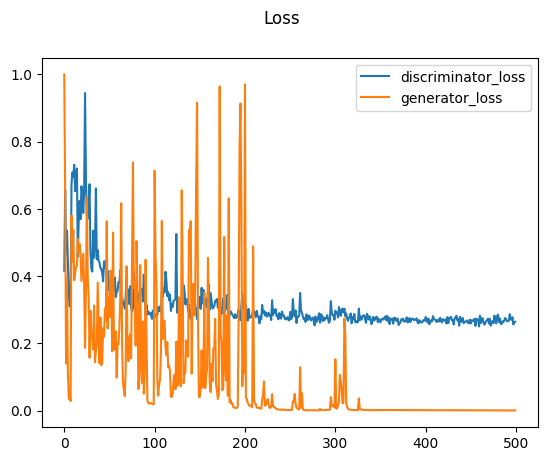

In [32]:
plt.suptitle("Loss")
plt.plot(history.history["discriminator_loss"], label="discriminator_loss")
plt.plot(history.history["generator_loss"], label="generator_loss")
plt.legend()
plt.show()

The decreasing total loss indicates that the model has learned successfully.

## Testing Out The Generator

In [56]:
import os
from tensorflow.keras.models import load_model

generator = load_model(os.path.join("models", "g_134.h5"))

1/1 [==============================] - 0s 23ms/step


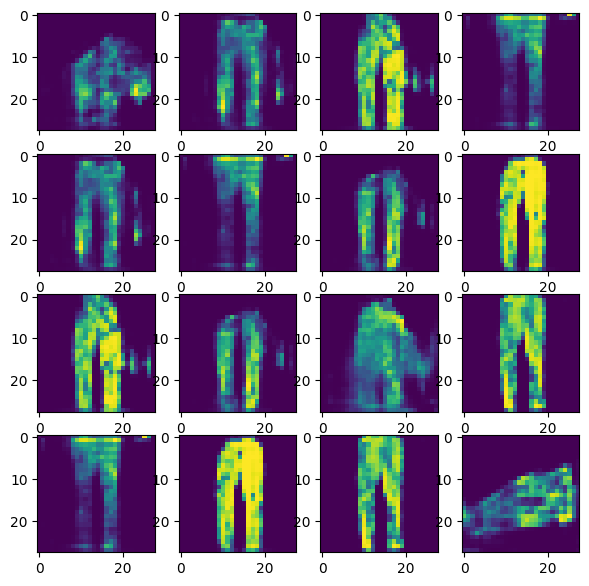

In [58]:
test_images = generator.predict(np.random.randn(16, 128, 1))

(figure, subplots) = plt.subplots(ncols=4, nrows=4, figsize=(7,7))
for i in range(4):
    for j in range(4):
        subplots[i][j].imshow(test_images[(i+1) * (j+1) - 1])

1/1 [==============================] - 0s 75ms/step


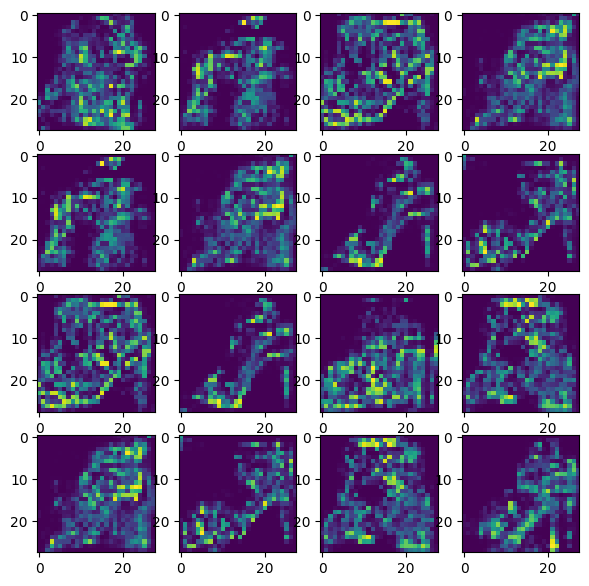

In [61]:
generator = load_model(os.path.join("models", "g_488.h5"))

test_images = generator.predict(np.random.randn(16, 128, 1))

(figure, subplots) = plt.subplots(ncols=4, nrows=4, figsize=(7,7))
for i in range(4):
    for j in range(4):
        subplots[i][j].imshow(test_images[(i+1) * (j+1) - 1])

1/1 [==============================] - 0s 73ms/step


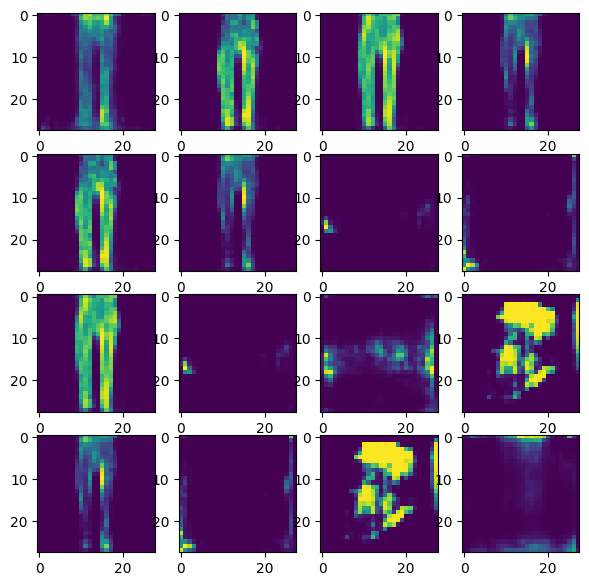

In [70]:
generator = load_model(os.path.join("models", "g_151.h5"))

test_images = generator.predict(np.random.randn(16, 128, 1))

(figure, subplots) = plt.subplots(ncols=4, nrows=4, figsize=(7,7))
for i in range(4):
    for j in range(4):
        subplots[i][j].imshow(test_images[(i+1) * (j+1) - 1])

## Conclusion
We were able to train the GAN on several low resolution images of clothing items so that the trained generator model successfully created images resembling the originals.

### Future Work
- The subclassed model takes a lot of compute power and time to train. On an RTX 2060 GPU, 500 epochs took over 440 minutes. I would like to improve this in my future models. 
- Most of the model checkpoints produced poor quality images, and even the best checkpoints were not perfect. It's likely that more training time could improve this.
- The callback function saving checkpoints was written to save entire models which led to the `models` folder growing past 6 GB. It would be better to save model weights only on future projects.
- Finally, this model creates random images of the types it was trained on. I would like to work on a model that can generate images of specified labels. 